In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json

import scanpy
import anndata

from tqdm import tqdm

In [2]:

fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")

chromosome = 'chrY'


In [3]:
data_gtf = pd.read_hdf(fdir_processed / f'geuvadis.preprocessed.h5', key = 'gtf')
# data_gtf = data_gtf.loc[data_gtf['seqname'] == chromosome]

data_header = pd.read_hdf(fdir_processed / f'geuvadis.preprocessed.h5', key='header')

data_geuvadis =  pd.read_hdf(fdir_processed / f'geuvadis.preprocessed.h5', key = 'geuvadis')
# data_geuvadis = data_geuvadis[data_gtf.index]

# data_geuvadis['sex'] =  data_header.loc[data_geuvadis.index, 'Sex']
# data_geuvadis

adata = anndata.AnnData(X=data_geuvadis, 
                        var=data_gtf.loc[data_geuvadis.columns], 
                        obs=data_header.loc[data_geuvadis.index]) 

In [4]:
columns = []
for column in adata.obs.columns:
    length = len(adata.obs[column].unique())
    if 1 < length < 10:
        columns.append(column)
        print(column)

AvgSpotLen
Center Name
DATASTORE filetype
ENA-FIRST-PUBLIC (run)
Experimental_Factor:_laboratory (exp)
Experimental_Factor:_population (exp)
INSDC_first_public
population
ReleaseDate
version
Sex


In [5]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(adata[:, adata.var['seqname'] == 'chrY'].X)


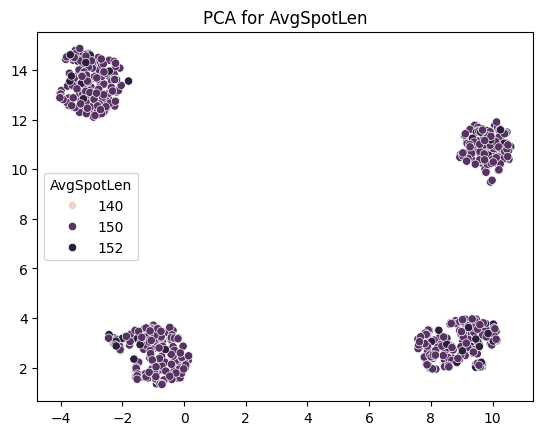

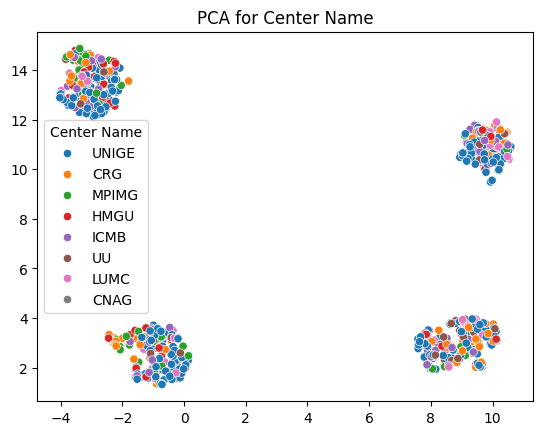

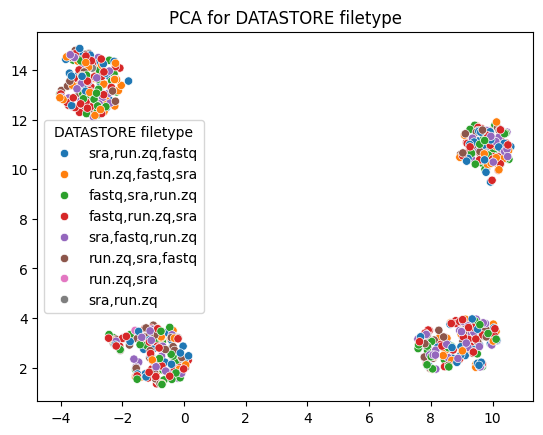

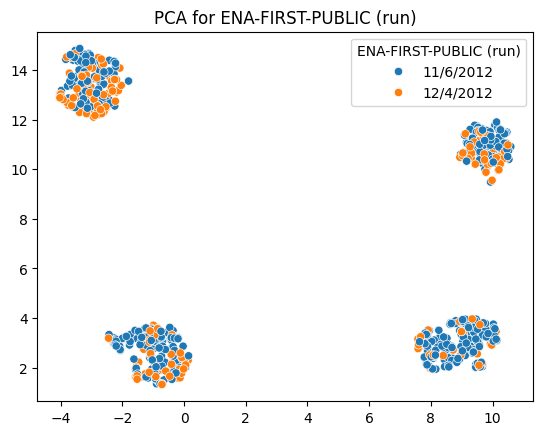

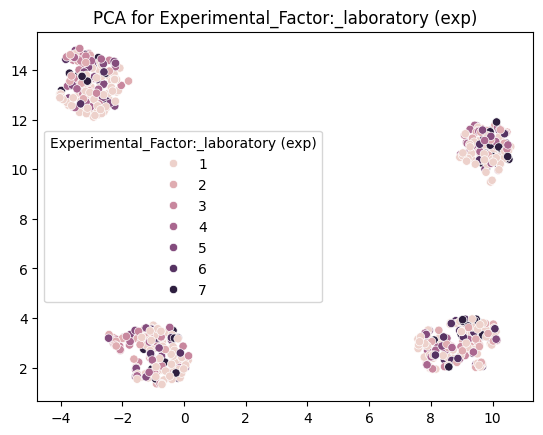

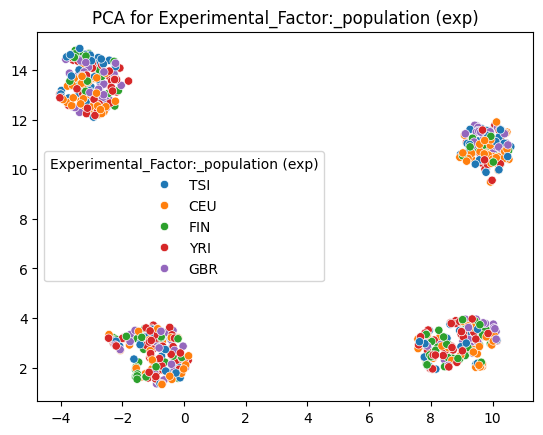

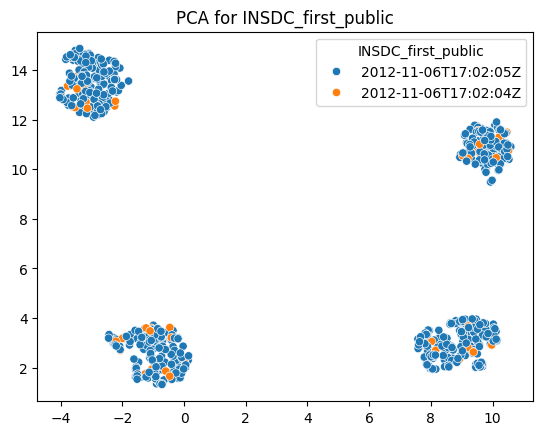

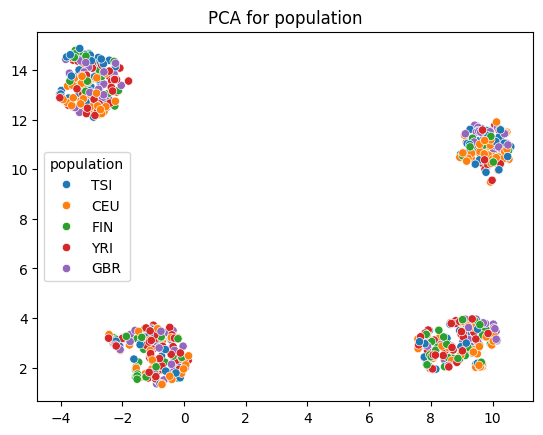

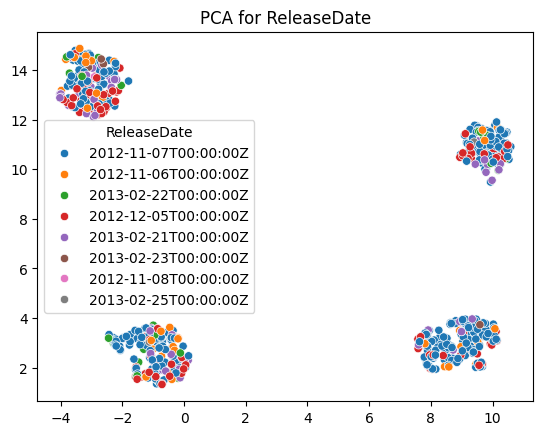

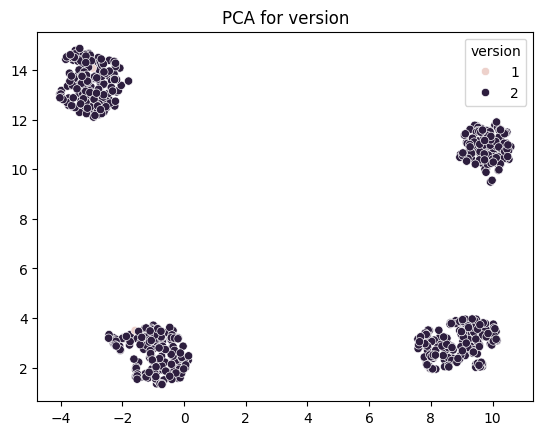

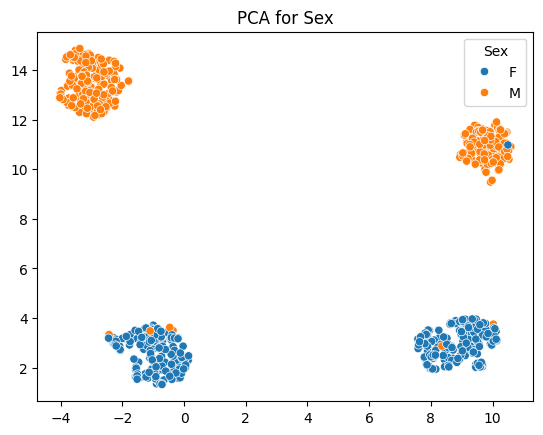

In [6]:
for c in columns:
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=adata.obs[c]
        # hue=adata.obs['Sample_name'].str[:-5]
    )
    plt.title(f'PCA for {c}')
    plt.show()

Text(0.5, 1.0, 'PCA for chrY')

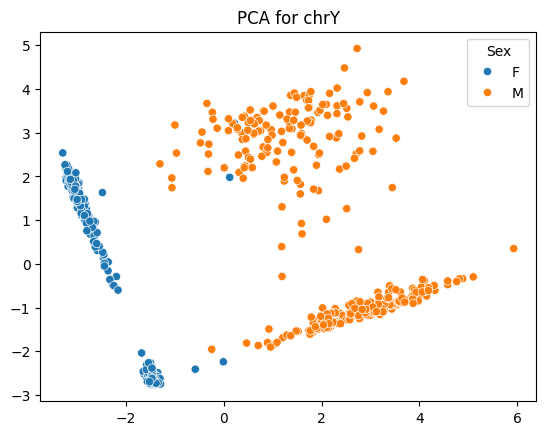

In [7]:
# reducer = umap.UMAP()
reducer = PCA(2)
embedding = reducer.fit_transform(
    adata[:, adata.var['seqname'] == chromosome].X
    # adata.X
)

sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=adata.obs['Sex']
    # hue=clusters.labels_
)
plt.title(f'PCA for {chromosome}')


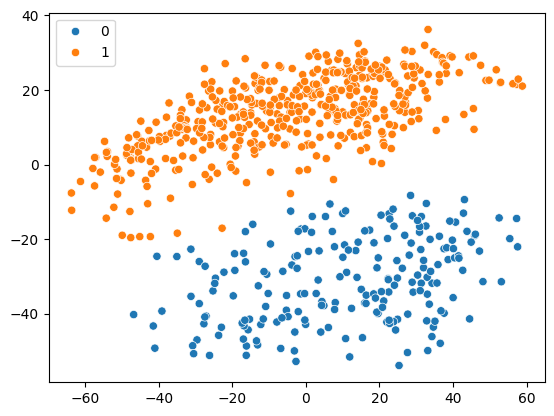

In [22]:
from sklearn.cluster import KMeans, DBSCAN

reducer = PCA(2)
embedding = reducer.fit_transform(
    adata.X)

clusters = KMeans(2).fit(embedding)
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=clusters.labels_,
    palette='tab10'
)
plt.show()

In [9]:
adata.layers['normalized']  = StandardScaler().fit_transform(adata.X)
adata_chrY = adata[:, adata.var['seqname'] == 'chrY']

Text(0.5, 1.0, 'PCA for chrY')

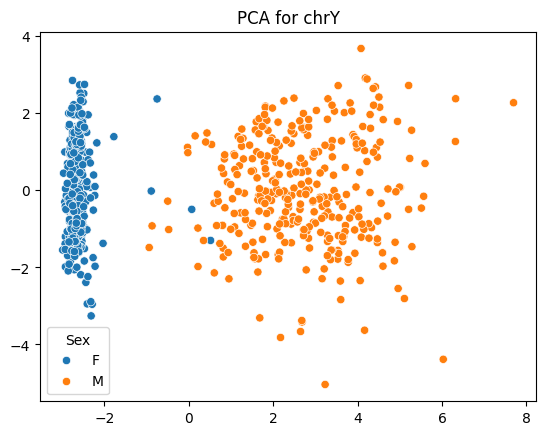

In [10]:
reducer = PCA(2)
embedding = reducer.fit_transform(
    adata_chrY.layers['normalized']
    # adata.X
)

sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=adata_chrY.obs['Sex']
    # hue=clusters.labels_
)
plt.title(f'PCA for {chromosome}')

<Axes: xlabel='value', ylabel='Count'>

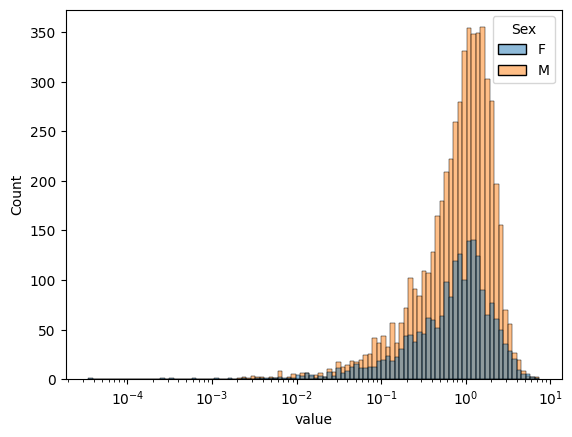

In [11]:
data_chrY = adata_chrY.to_df(layer='normalized')
data_chrY['Sex'] = adata.obs['Sex']

sns.histplot(data_chrY.melt('Sex'), x='value', hue='Sex', log_scale=True)


In [12]:
pseudoautosoms_Y1 = [10001, 2781479]
pseudoautosoms_X1 = [10001, 2781479]
pseudoautosoms_Y2 = [56887903, 57217415]
pseudoautosoms_X2 = [155701383, 156030895]

pseudoauto = adata_chrY[:, 
                        ((adata_chrY.var["start"] > pseudoautosoms_Y1[0]) & 
                        (adata_chrY.var["end"] < pseudoautosoms_Y1[1])) |
                        ((adata_chrY.var["start"] > pseudoautosoms_Y2[0]) & 
                        (adata_chrY.var["end"] < pseudoautosoms_Y2[1]))
                        ]

pseudoauto.to_df()

,MSTRG.36690.8,MSTRG.36691.6,MSTRG.36702.6,ENST00000711210.1,MSTRG.36705.7,MSTRG.36705.21,ENST00000711197.1,MSTRG.36701.2,ENST00000711235.1,ENST00000711237.1,MSTRG.36708.10,MSTRG.36706.2,ENST00000711159.1,ENST00000711154.1,ENST00000711151.1,ENST00000711264.1
ERR188021,0.298357,0.186729,0.003915,0.000000,0.000000,0.849876,0.201128,0.003828,1.216267,0.098222,0.181893,1.006452,0.000000,0.387026,0.125729,0.317747
ERR188022,0.391138,0.248443,0.034692,0.000000,1.400249,0.791706,0.000000,0.141921,1.650085,0.094308,0.420963,0.000000,0.629936,0.111879,0.521427,0.335822
ERR188023,0.386376,0.887412,1.850737,0.645902,0.058217,0.000000,4.939532,0.234429,1.505354,0.047298,0.761579,0.619390,0.609949,0.099160,0.018530,0.136519
ERR188024,0.482428,1.482096,0.000000,0.000000,0.213939,0.000000,0.000000,0.188400,1.248135,0.225820,0.068020,0.185396,0.000000,0.000000,0.247344,0.293758
ERR188025,0.000000,0.320804,0.880653,0.583724,0.378604,0.000000,4.414067,0.029714,1.042062,0.047497,0.070789,0.000000,2.202585,0.000000,0.019303,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR204940,2.967808,0.892686,2.390805,1.949501,1.710294,0.000000,0.000000,0.949932,0.000000,2.268825,0.000000,2.251692,2.733119,0.000000,1.450226,0.000000
ERR205020,0.000000,0.305973,0.098541,0.697163,0.231066,0.237954,0.000000,0.605161,1.114109,0.000000,0.653943,0.000000,0.000000,0.666603,0.175914,0.000000
ERR205021,0.124237,0.617045,0.056083,0.000000,0.683929,0.409254,0.289369,0.357930,1.836630,0.118623,0.000000,0.000000,0.954314,0.560058,0.505521,0.000000
ERR205022,0.514327,0.405389,0.046652,0.000000,0.000000,1.489940,0.267724,0.510294,0.000000,2.107804,0.433874,2.448610,0.000000,0.473575,0.000000,0.000000


In [13]:
adata_true_Y = adata_chrY[:, 
                          (adata_chrY.var["end"] < pseudoautosoms_Y1[0]) | 
                          ((adata_chrY.var["start"] > pseudoautosoms_Y1[1]) & (adata_chrY.var["end"] < pseudoautosoms_Y2[0])) |
                          (adata_chrY.var["start"] > pseudoautosoms_Y2[1]) 
                          ]
adata_true_Y.X.shape

(667, 14)

<Axes: xlabel='value', ylabel='Count'>

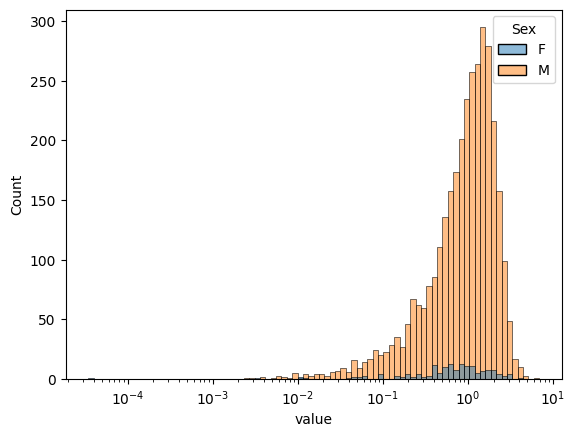

In [14]:
true_Y = adata_true_Y.to_df(layer='normalized')
true_Y['Sex'] = adata_true_Y.obs['Sex']
sns.histplot(true_Y.melt('Sex'), x='value', hue='Sex', log_scale=True)


In [15]:
data_chrY

,MSTRG.36690.8,MSTRG.36691.6,MSTRG.36702.6,ENST00000711210.1,MSTRG.36705.7,MSTRG.36705.21,ENST00000711197.1,MSTRG.36701.2,ENST00000711235.1,ENST00000711237.1,...,MSTRG.36785.2,MSTRG.36786.4,ENST00000471409.1,ENST00000485154.1,MSTRG.36833.1,ENST00000711264.1,MSTRG.36809.22,ENST00000485584.1,MSTRG.36838.1,Sex
ERR188021,-0.127011,-0.739120,-0.569222,-0.648646,-0.873283,1.205548,-0.844042,-0.770979,0.985511,-0.721790,...,-0.486422,-0.814023,-0.827206,-0.830285,-0.838756,-0.449294,-0.608743,-0.688842,-0.703077,F
ERR188022,0.013717,-0.657355,-0.529482,-0.648646,2.066512,1.057311,-0.937634,-0.475697,1.634079,-0.728819,...,0.708170,-0.814023,1.970578,2.285028,1.215550,-0.421816,1.570305,1.150316,-0.200065,M
ERR188023,0.006495,0.189217,1.815430,0.456125,-0.751058,-0.960215,1.360910,-0.277886,1.417702,-0.813254,...,-0.584671,-0.814023,-0.827206,-0.830285,-0.832641,-0.724814,-0.588969,-0.688842,-0.703077,F
ERR188024,0.152184,0.977114,-0.574277,-0.648646,-0.424121,-0.960215,-0.937634,-0.376311,1.033154,-0.492606,...,-0.739208,-0.814023,-0.827206,-0.830285,-0.871049,-0.485765,-0.608743,-0.688842,-0.703077,F
ERR188025,-0.579552,-0.561484,0.562838,0.349774,-0.078412,-0.960215,1.116392,-0.715627,0.725071,-0.812898,...,-0.739208,-0.814023,-0.827206,-0.830285,-0.871049,-0.932363,-0.599048,-0.688842,-0.703077,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR204940,3.921952,0.196203,2.512776,2.685841,2.717446,-0.960215,-0.937634,1.252071,-0.832835,3.176899,...,1.147816,-0.814023,-0.827206,-0.830285,-0.871049,-0.932363,-0.288794,-0.688842,-0.529697,F
ERR205020,-0.579552,-0.581133,-0.447039,0.543803,-0.388164,-0.353830,-0.937634,0.514849,0.832783,-0.898208,...,0.193856,1.116015,0.188399,1.618339,-0.503386,-0.932363,2.142475,-0.389120,-0.255830,M
ERR205021,-0.391112,-0.168994,-0.501862,-0.648646,0.562613,0.082699,-0.802980,-0.013804,1.912967,-0.685146,...,-0.043666,0.393521,-0.355908,-0.120530,-0.871049,-0.932363,0.263618,-0.476786,-0.329482,M
ERR205022,0.200568,-0.449417,-0.514039,-0.648646,-0.873283,2.836641,-0.813053,0.311994,-0.832835,2.887684,...,-0.522226,-0.814023,-0.827206,-0.830285,-0.871049,-0.932363,-0.570194,-0.688842,-0.703077,F


In [16]:
true_Y

,MSTRG.36720.1,MSTRG.36713.13,MSTRG.36782.3,MSTRG.36782.10,MSTRG.36778.7,ENST00000495478.1,MSTRG.36785.2,MSTRG.36786.4,ENST00000471409.1,ENST00000485154.1,MSTRG.36833.1,MSTRG.36809.22,ENST00000485584.1,MSTRG.36838.1,Sex
ERR188021,-0.831536,-0.660546,-0.367258,-0.688769,-1.009921,-0.785670,-0.486422,-0.814023,-0.827206,-0.830285,-0.838756,-0.608743,-0.688842,-0.703077,F
ERR188022,0.542040,2.316229,-0.734843,2.825992,-1.009921,2.089803,0.708170,-0.814023,1.970578,2.285028,1.215550,1.570305,1.150316,-0.200065,M
ERR188023,-0.835938,-0.643680,-0.501771,-0.710536,-0.722815,-0.785670,-0.584671,-0.814023,-0.827206,-0.830285,-0.832641,-0.588969,-0.688842,-0.703077,F
ERR188024,-0.846822,-0.688966,-0.456331,-0.710536,2.031044,-0.785670,-0.739208,-0.814023,-0.827206,-0.830285,-0.871049,-0.608743,-0.688842,-0.703077,F
ERR188025,-0.836359,-0.688966,-0.665620,-0.710536,-0.202702,-0.785670,-0.739208,-0.814023,-0.827206,-0.830285,-0.871049,-0.599048,-0.688842,-0.703077,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR204940,1.493158,-0.505522,-0.768401,-0.710536,1.530880,-0.785670,1.147816,-0.814023,-0.827206,-0.830285,-0.871049,-0.288794,-0.688842,-0.529697,F
ERR205020,-0.104455,1.980339,2.468624,2.136151,-1.009921,0.639495,0.193856,1.116015,0.188399,1.618339,-0.503386,2.142475,-0.389120,-0.255830,M
ERR205021,-0.421308,-0.682909,1.088644,0.758476,-1.009921,-0.439830,-0.043666,0.393521,-0.355908,-0.120530,-0.871049,0.263618,-0.476786,-0.329482,M
ERR205022,-0.846822,-0.652578,-0.584543,-0.710536,-0.036713,-0.785670,-0.522226,-0.814023,-0.827206,-0.830285,-0.871049,-0.570194,-0.688842,-0.703077,F


In [17]:
data_geuvadis

,MSTRG.239.15,MSTRG.249.12,MSTRG.250.13,ENST00000432521.2,MSTRG.259.5,ENST00000435221.6,MSTRG.259.7,MSTRG.259.9,ENST00000378567.8,MSTRG.237.18,...,MSTRG.30211.1,MSTRG.30408.1,MSTRG.30433.1,ENST00000363945.1,MSTRG.32721.13,ENST00000358022.6,MSTRG.36284.1,MSTRG.36809.22,ENST00000485584.1,MSTRG.36838.1
ERR188021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.717116,0.421942,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ERR188022,0.000000,0.000000,0.799756,1.642583,1.559544,1.346990,1.463835,0.468743,0.000000,0.000000,...,0.278405,0.000000,2.210809,0.373931,0.000000,0.320373,0.382722,1.470729,1.347314,0.349782
ERR188023,1.041698,0.172106,0.181875,0.341884,0.690392,0.000000,0.000000,0.000000,2.055131,0.000000,...,0.982559,0.148974,0.981267,0.794413,0.305703,0.153957,0.728266,0.013347,0.000000,0.000000
ERR188024,1.718304,2.636580,0.000000,2.412521,2.015744,2.011945,1.641659,2.708559,1.183267,0.000000,...,0.764759,0.645045,1.971979,1.484448,0.811534,0.737685,0.000000,0.000000,0.000000,0.000000
ERR188025,0.092789,0.325591,0.000000,0.198449,0.000000,0.310230,1.547893,1.979350,0.000000,1.278243,...,0.488217,0.147106,0.810465,0.543106,0.000000,0.233628,0.000000,0.006544,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR204940,0.000000,0.000000,2.407727,0.000000,0.000000,0.000000,0.000000,0.000000,1.551798,0.000000,...,3.289873,3.606890,3.795911,0.000000,0.357103,2.424006,3.423396,0.215947,0.000000,0.120564
ERR205020,0.000000,0.000000,0.789096,0.000000,0.000000,1.115314,2.104318,1.862446,0.000000,0.743505,...,0.400225,0.778359,1.510771,0.000000,0.000000,1.163828,0.473227,1.856910,0.219568,0.311004
ERR205021,0.000000,2.766302,0.238701,0.000000,2.002541,2.427571,4.303934,1.500727,3.062893,0.757271,...,0.000000,0.000000,2.417925,0.000000,0.000000,0.000000,0.000000,0.588792,0.155346,0.259788
ERR205022,0.000000,2.351532,1.025341,1.407937,0.000000,0.000000,0.000000,0.000000,2.688904,0.000000,...,1.020148,0.748980,1.716177,0.000000,0.324686,0.319735,0.000000,0.026018,0.000000,0.000000


In [18]:
data_chrY_processed = pd.read_hdf(fdir_traintest / f'geuvadis.preprocessed.sex.h5', key='chrY')
data_autosom_processed = pd.read_hdf(fdir_traintest / f'geuvadis.preprocessed.sex.h5', key='autosome')



In [19]:
(data_chrY_processed.columns.difference(data_autosom_processed.columns))

Index(['ENST00000471409.1', 'ENST00000485154.1', 'ENST00000485584.1',
       'ENST00000495478.1', 'MSTRG.36713.13', 'MSTRG.36720.1', 'MSTRG.36778.7',
       'MSTRG.36782.10', 'MSTRG.36782.3', 'MSTRG.36785.2', 'MSTRG.36786.4',
       'MSTRG.36809.22', 'MSTRG.36833.1', 'MSTRG.36838.1'],
      dtype='object')

In [20]:
true_Y.columns

Index(['MSTRG.36720.1', 'MSTRG.36713.13', 'MSTRG.36782.3', 'MSTRG.36782.10',
       'MSTRG.36778.7', 'ENST00000495478.1', 'MSTRG.36785.2', 'MSTRG.36786.4',
       'ENST00000471409.1', 'ENST00000485154.1', 'MSTRG.36833.1',
       'MSTRG.36809.22', 'ENST00000485584.1', 'MSTRG.36838.1', 'Sex'],
      dtype='object')

In [21]:
true_Y.columns.difference((data_chrY_processed.columns.difference(data_autosom_processed.columns)))

Index(['Sex'], dtype='object')